In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pandas_path import path
from pathlib import Path
from PIL import Image
#import pytorch_lightning as pl
import torch

ModuleNotFoundError: No module named 'torch'

In [4]:
DATA_DIR = Path.cwd().parent.resolve() / "on_cloud_n/data"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [5]:
BANDS = ["B02", "B03", "B04", "B08"]

In [10]:
train_meta = pd.read_csv("../on_cloud_n/train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [11]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [12]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

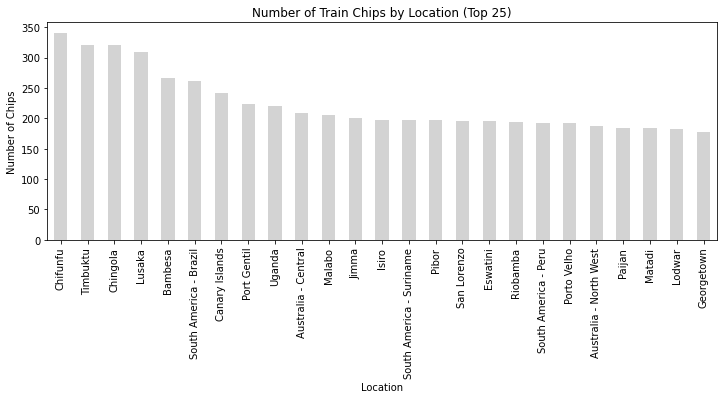

In [13]:
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

In [14]:
# Extract year of chip from datetime
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2018,326
2019,1015
2020,10407


In [15]:
# First and last datetime for the chips
train_meta["datetime"].min(), train_meta[
    "datetime"
].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [16]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


In [17]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

AttributeError: 'Series' object has no attribute 'path'